# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [3]:
!pip install --upgrade %matplotlib

ERROR: Invalid requirement: '%matplotlib'


In [4]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [5]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [42]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_loc = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [71]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    sfo_data_housing_mean = sfo_data['housing_units'].groupby("year").mean()
    #fig_housing_units = plt.figure()
    sfo_data_housing_plt = sfo_data_housing_mean.plot.bar()
    sfo_data_housing_plt.set_xlabel("Year", fontsize=14)
    sfo_data_housing_plt.set_ylabel("Housing Units", fontsize=14)
    sfo_data_housing_plt.set_title("Housing Units in San Francisco from 2010 - 2016", fontweight="bold", fontsize=16)


    sfo_data_housing_min = min(sfo_data_housing_mean)
    sfo_data_housing_max = max(sfo_data_housing_mean)
    sfo_data_housing_std = sfo_data_housing_mean.std()


    sfo_data_housing_plt.set_ylim(sfo_data_housing_min-sfo_data_housing_std, sfo_data_housing_max + sfo_data_housing_std)
    #plt.close(fig_housing_units)
  
    #plt.show()
    #return pn.pane.Matplotlib(tight=True)
    return sfo_data_housing_plt


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    sfo_avg_sale_price = sfo_data[["sale_price_sqr_foot", "gross_rent"]].groupby("year").mean()
    sfo_avg_price_plt = sfo_avg_sale_price['gross_rent'].plot()
    sfo_avg_price_plt.set_xlabel("Year", fontsize=14)
    sfo_avg_price_plt.set_ylabel("Price per SqFt", fontsize=14)
    sfo_avg_price_plt.set_title("Average Price per SqFt by Year", fontweight="bold", fontsize=16)
    #plt.show();
    
    return pn.pane.Matplotlib(tight=True)


def average_sales_price():
    """Average Sales Price Per Year."""
     
    sfo_avg_sale_price = sfo_data[["sale_price_sqr_foot", "gross_rent"]].groupby("year").mean()
    sfo_avg_price_plt = sfo_avg_sale_price['sale_price_sqr_foot'].plot()
    sfo_avg_price_plt.set_xlabel("Year", fontsize=14)
    sfo_avg_price_plt.set_ylabel("Price per SqFt", fontsize=14)
    sfo_avg_price_plt.set_title("Average Price per SqFt by Year", fontweight="bold", fontsize=16)
    #plt.show();

    return pn.pane.Matplotlib(tight=True)

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    df_neighbor = sfo_data.groupby([sfo_data.index,'neighborhood']).mean()
    df_neighbor.reset_index(inplace=True)
    df_neighbor.rename(columns={'level_0':'year'}, inplace=True)
    df_neighbor.head(10)

    neighborhood = df_neighbor.hvplot.line(
    'year',
    'sale_price_sqr_foot',
    xlabel="Year",
    ylabel="Avg",
    groupby="neighborhood")
    
    return neighborhood

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    df_top_most_expensive_neighborhood = sfo_data.groupby([sfo_data.index,'neighborhood']).mean()
    df_top_most_expensive_neighborhood.head(10)
    df_top_most_expensive_neighborhood = df_top_most_expensive_neighborhood.reset_index()

    expensive_neighborhood = df_top_most_expensive_neighborhood.hvplot.bar(
    'neighborhood',
    'sale_price_sqr_foot',
    xlabel="Year",
    ylabel="Avgerage Sales",
    title='Top 10 Expensive Neighborhood',
    height=600,
    width=1250,
    rot=70)
    return expensive_neighborhood



def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    # YOUR CODE HERE!

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    df_top_most_expensive_neighborhood = sfo_data.groupby([sfo_data.index,'neighborhood']).mean()
    df_top_most_expensive_neighborhood.head(10)
    df_top_most_expensive_neighborhood = df_top_most_expensive_neighborhood.reset_index()

    
    expensive_neighborhood = px.parallel_coordinates(
    df_top_most_expensive_neighborhood,
    color="sale_price_sqr_foot",   
    color_continuous_scale=px.colors.sequential.Inferno,)
    
    return expensive_neighborhood


def parallel_categories():
    """Parallel Categories Plot."""
    
    df_top_most_expensive_neighborhood = sfo_data.groupby(['neighborhood']).apply(lambda x: x.sort_values(['sale_price_sqr_foot'],ascending=False)).reset_index(drop=True)
    df_top_most_expensive_neighborhood = df_top_most_expensive_neighborhood.nlargest(11,'sale_price_sqr_foot')

    
    expensive_neighborhood = px.parallel_categories(
    #px.parallel_categories(
    df_top_most_expensive_neighborhood,
    dimensions=['neighborhood','sale_price_sqr_foot','housing_units','gross_rent'],
    width = 1200,
    color='sale_price_sqr_foot',    
    color_continuous_scale=px.colors.sequential.Inferno)
    
    
    return expensive_neighborhood



def neighborhood_map():
    """Neighborhood Map."""

    df_neighbor_cost = sfo_data.groupby('neighborhood').mean()
    df_neighbor_cost.reset_index(inplace=True)
    df_neighbor_cost.rename(columns={'neighborhood':'Neighborhood'}, inplace=True) # I had to rename (exact name) the column to join
    
    df_neighbor_combine = pd.concat([df_neighborhood_loc,df_neighbor_cost['sale_price_sqr_foot'],df_neighbor_cost['housing_units'],df_neighbor_cost['gross_rent']],
                                   axis=1)
    
    
    map_plot = px.scatter_mapbox(
    df_neighbor_combine,
    title='Average Sales Price Per Square Foot and Gross Rent in San Francisco',
    hover_name='Neighborhood',
    lat='Lat',
    lon='Lon',
    color='gross_rent',
    size='sale_price_sqr_foot',
    height=(600),
    zoom=10)
    
    
    return map_plot


def sunburst():
    """Sunburst Plot."""
    
    df_neighbor_cost = sfo_data.groupby(['year','neighborhood']).mean()
    df_neighbor_cost.reset_index(inplace=True)
    df_neighbor_cost.rename(columns={'neighborhood':'Neighborhood'}, inplace=True) # I had to rename (exact name) the column to join


    df_neighbor_cost_sorted = df_neighbor_cost.groupby(['year']).apply(lambda x: x.sort_values(['sale_price_sqr_foot'],ascending=False)).reset_index(drop=True)
    df_neighbor_costby_yr = df_neighbor_cost_sorted.groupby(['year']).head(10)
    
    
    sun_plot = px.sunburst(
        #df_neighbor_combine,
        #df_neighbor_cost_sorted,
        df_neighbor_costby_yr,
        path=['year','Neighborhood'],
        values='sale_price_sqr_foot',    
        title ='Average Sales Price Per Square Foot and Gross Rent in San Francisco', 
        labels='Neighborhood',
    
        width = 1000,
        height = 1000)
        
           # sun_plot.show()
    
    
    
    return sun_plot

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

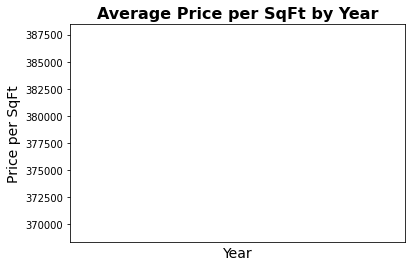

In [72]:
# Create a Title for the Dashboard
welcome_column = pn.Column(' This Dashboard allows you to visualize vestment opportunities in San Francisco',neighborhood_map())

yearly_market_analysis = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())

neighborhood_analysis = pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())

parallel_plot_analysis = pn.Column(parallel_coordinates(), parallel_categories())

sunbruse_plot_analysis = pn.Column(sunburst())


panel_content = pn.Tabs(
    ('Welcome', welcome_column),
    ('Yearly Market Analysis', yearly_market_analysis),
    ('Neighborhood Analysis', neighborhood_analysis),
    ('Parallel Plot Analysis', parallel_plot_analysis),
    ('Sunburst Plot Analysis',sunbruse_plot_analysis)
)

panel = pn.Column(f'# Real Estate Analysis of San Francisco from {sfo_data.index.min()} to {sfo_data.index.max()}<br/>',
                  panel_content
                 )


## Serve the Panel Dashboard

In [73]:
# Serve the# dashboard
panel.servable()

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Str(AxesSubplot)
            [1] Matplotlib(None, tight=True)
            [2] Matplotlib(None, tight=True)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
        [3] Column
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [4] Column
            [0] Plotly(Figure)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(None, tight=True)

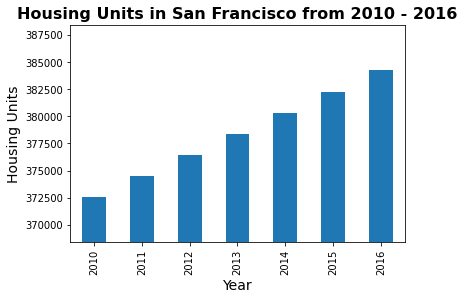

In [15]:
# housing_units_per_year()
housing_units_per_year()

In [ ]:
# average_gross_rent()
average_gross_rent()

In [ ]:
# average_sales_price()
average_sales_price()

In [ ]:
# average_price_by_neighborhood()
average_price_by_neighborhood()

In [ ]:
# top_most_expensive_neighborhoods()
top_most_expensive_neighborhoods()

In [ ]:
# most_expensive_neighborhoods_rent_sales()


In [ ]:
# neighborhood_map().show()
neighborhood_map()#.show()

In [ ]:
# parallel_categories()
parallel_categories()

In [ ]:
# parallel_coordinates()
parallel_coordinates()

In [ ]:
# sunburst()
sunburst()